# IN3062 – Introduction to Artificial Intelligence

## *Coursework Notebook*

#### Sever Miranbeg, Akif Karakus, Moeen Younis

# Introduction

This notebook documents analysis done on a [dataset](https://www.kaggle.com/mirichoi0218/insurance) collating records of anonymous individuals in the US on health insurance premiums in order to identify the most effective AI model for predicting the cost of a healthcare package for a single person based on several factors, some of which include their **age**, **gender** and [**BMI**](https://en.wikipedia.org/wiki/Body_mass_index) value.

## Reading in the data

Firstly, we import the required [`os`](https://docs.python.org/3.8/library/os.html) and [`pandas`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/index.html) modules in order to load the CSV file (`healthcare.csv`) containing the our data and create a new [`DataFrame`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/frame.html) object. The [`head`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.head.html) function is then used to display the object's columns and first 5 rows.

In [1]:
# Required classes/modules
import os
import pandas as pd

# Reads in CSV to initialise a DataFrame with dataset, then outputs the first 5 rows
path = "../data/"
read = os.path.join(path, "healthcare.csv")
df = pd.read_csv(read)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Referencing the [`shape`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.shape.html) property of our `DataFrame` object returns a tuple representing its dimensions (number of rows by number of columns).

In [2]:
df.shape    # Returns the dimensions (rows, cols)

(1338, 7)

As shown above, there are 1338 rows (observations) in addition to 7 columns (features) to work with, which is sufficient to build a reliable model. The following section covers the steps taken to prepare the data for training.

## Analysing and visualising the data

Before we begin building any models using [`sklearn`](https://scikit-learn.org/stable/modules/classes.html) and any other modules, it is important that we make sense of the data by visualising it. This gives us a clearer insight into the type of data we are working with, making any trends more apparent.

To visualise certain features (as well as models and predictions later on) we'll be using a combination of the powerful data visualisation and graphical plotting modules [`seaborn`](https://seaborn.pydata.org/api.html) and [`matplotlib`](https://matplotlib.org/stable/api/).

The [`savefig`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html) function provided by `matplotlib` will be reused to save each plot produced (in `.png` format) within `models/`, found in the project root.

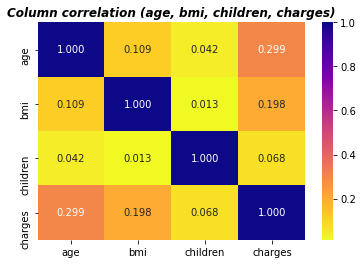

In [3]:
# Required classes/modules
import seaborn as sns
import matplotlib.pyplot as plt

# Generates a heatmap of column correlation
corr_feat_fig01 = sns.heatmap(df.corr(), cmap="plasma_r", annot=True, fmt=".3f")
corr_feat_fig01.set_title("Column correlation (age, bmi, children, charges)", size="large", style="italic", weight="bold")
# corr_feat_fig01.get_figure().savefig("../models/corr_feat_fig01.png", bbox_inches="tight")
plt.show()

The figure shown above (produced by [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) from `seaborn`) visually describes how closely correlated each of the numeric features in our dataset are to each other, on a scale of 0 (no correlation) to 1 (fully correlated). The [`corr`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.corr.html) function produces the correlation matrix used in the call to `heatmap`.

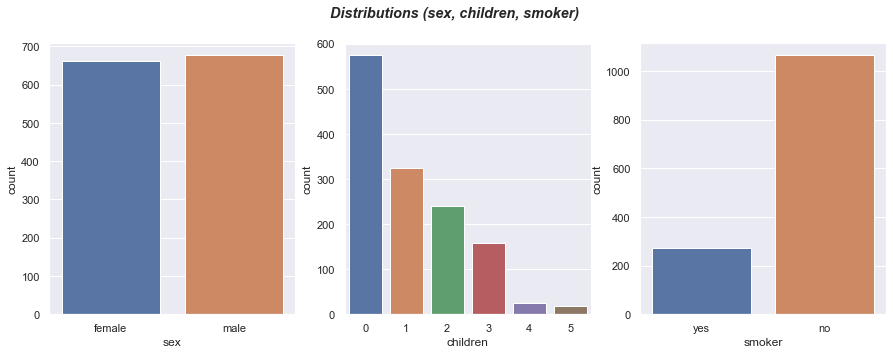

In [4]:
sns.set_theme()                                   # Sets theme for all plots

# Initialises invidivual plots for figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Distributions (sex, children, smoker)", size="large", style="italic", weight="bold")
sns.countplot(x="sex", data=df, ax=ax[0])         # Shows a countplot of gender distribution
sns.countplot(x="children", data=df, ax=ax[1])    # Shows a countplot of children distribution
sns.countplot(x="smoker", data=df, ax=ax[2])      # Shows a countplot of smoker distribution

# fig.savefig("../models/bar_feat_fig02.png", bbox_inches="tight")
plt.show()

From the set of [`countplot`](https://seaborn.pydata.org/generated/seaborn.countplot.html) figures produced above, we can come to the following conclusions:
- The distribution of male and female records is fairly equal.
- The majority of records in the dataset indicate that those on a healthcare plan had no children, and the count value decreased gradually from 1-3 children and then dropped drastically and stabilised between 4 and 5 children.
- There is roughly 4 times as many non-smokers than there are smokers.

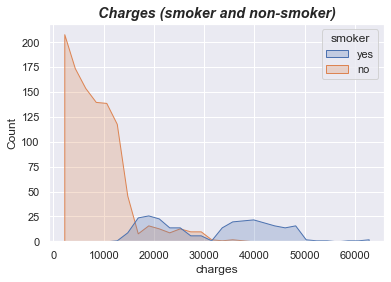

In [5]:
# Shows distribution of charges between smokers and non-smokers
feat_fig03 = sns.histplot(df, x="charges", hue="smoker", 
        element="poly").set_title("Charges (smoker and non-smoker)", size="large", style="italic", weight="bold")
# feat_fig03.get_figure().savefig("../models/hist_feat_fig03.png", bbox_inches="tight")
plt.show()

From the [`histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) figure produced above, we can see that:
- The majority of non-smokers' charges were below 20,000 USD.
- There is a trend that shows smokers are paying more for medical fees in comparison to non-smokers.
- No non-smokers paid more than 40,000 whereas a lot of smokers were consistently paying more than 40,000 for medical fees.

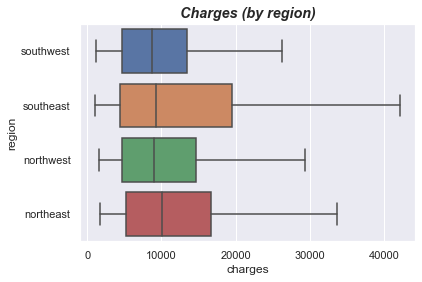

In [6]:
# Shows a boxplot for distribution of charges over each region, without outliers
feat_fig04 = sns.boxplot(data=df, x="charges", y="region", 
                showfliers=False).set_title("Charges (by region)", size="large", style="italic", weight="bold")
# feat_fig04.get_figure().savefig("../models/box_feat_fig04.png", bbox_inches="tight")
plt.show()

From the [`boxplot`](https://seaborn.pydata.org/generated/seaborn.boxplot.html) figure produced above, we can conclude that:
- The southeastern region has the largest distribution of charges as well as the largest interquartile range.
- The northeastern region has the highest median of charges out of the four regions.
- The southwestern region has the smallest distribution of charges.

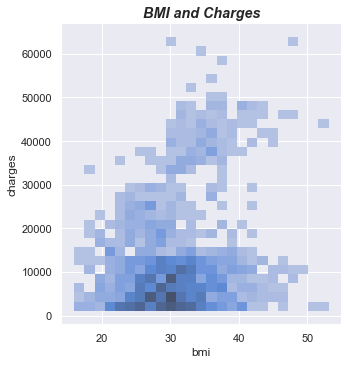

In [7]:
# Shows distribution of charges based on BMI values 
feat_fig05 = sns.displot(data=df, x="bmi", y="charges")
feat_fig05.ax.set_title("BMI and Charges", size="large", style="italic", weight="bold")
# feat_fig05.savefig("../models/dist_feat_fig05.png", bbox_inches="tight")
plt.show()

From the [`displot`](https://seaborn.pydata.org/generated/seaborn.displot.html) figure above, we can see that:
- The majority of patients have a BMI value between low-20 and mid-30 with a relatively lower healthcare charges.
- Though it isn't directly shown by this plot, higher BMI can correlate to a higher medical fee.

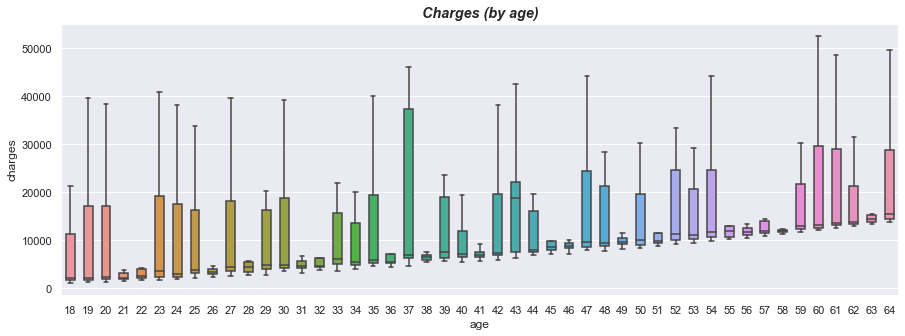

In [8]:
# Shows boxplots for correlation between ages and charges, omitting outliers
sns.set(rc={"figure.figsize": (15, 5)})
feat_fig06 = sns.boxplot(data=df, x="age", y="charges", 
        showfliers=False, width=0.5).set_title("Charges (by age)", size="large", style="italic", weight="bold")
# feat_fig06.get_figure().savefig("../models/box_feat_fig06.png", bbox_inches="tight")
plt.show()

The set of `boxplot` figures shown in the plot above illustrate the relationship between charges (target feature) and age. It is suggested that:
- The minimum cost of a healthcare plan increases the older an individual is. 
- The largest spread of charges occurs at age 37.
- Small distributions mean a few records for individuals of that age have been collected.  

## Preprocessing the data

Data preprocessing is essential in machine learning, as it ensures consistency in the data and relevant information used by a model, subsequently improving its ability to learn.

Almost all datasets present in the real world contain some discrepancies, requiring us to identify missing data. In the case of our dataset, NA/null values are represented by `NaN`. This can be done by calling either [`isna`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.isna.html) or [`isnull`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.isnull.html), which both produce the same output.

In [9]:
df.isna()    # Is each cell NA/null?

,age,sex,bmi,children,smoker,region,charges
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1333,False,False,False,False,False,False,False
1334,False,False,False,False,False,False,False
1335,False,False,False,False,False,False,False
1336,False,False,False,False,False,False,False


For a clearer summary of any NA/null values in the dataset, calling [`sum`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.sum.html) immediately after `isna` or `isnull` will calculate the number of `NaN` values found under each column in a given `DataFrame` object, as shown below.

In [10]:
df.isnull().sum()    # Outputs the number of NA/null values under each column

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

To retrieve relevant statistics (mean, ranges, quartiles, standard deviation) we made use of [`describe`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.describe.html). Non-numeric columns/features (`sex`, `smoker`, `region`) are excluded by default.

In [11]:
df.describe()    # Summary stats

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From the figures above, we see that:
- The average cost of a health insurance plan for an individual is 13,720 USD whilst the standard deviation lies at 12,110 USD.
    - This suggests that costs are fairly dispersed due to the relatively small difference between both values.
- The cheapest plan costs 1,122 USD in comparison to the most expensive at 63,770.
- The average age is 39, the youngest being 18 and the oldest 64.
- The average BMI value falls at around 31 with a standard deviation of 6.
    - This indicates that the spread in BMI values amongst individuals in the dataset is relatively small.
    
As a final step in preprocessing the data, we must convert categorical variables in the dataset into dummy or indicator variables. This is required as machine learning models cannot make use of non-numerical values.

We can make use of another function provided by the `pandas` library named [`get_dummies`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.get_dummies.html). This allows us to work with more features, allowing for higher accuracy in the predictions produced by models. This function applies [**one-hot encoding**](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics), a technique used to handle categorical (ordinal or nominal) variables by creating a column for each unique value the variable can take. These columns contain either 0 (representing false) or 1 (representing true).

In our case, the columns `sex` (male or female), `smoker` (smoker or not) and `region` (NE, NW, SE, SW) are all examples of nominal data.

In [12]:
df_proc = pd.get_dummies(df.copy(deep=True))    # Converts non-numerical columns into dummy/indicator columns
df_proc.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


A deep copy of the original dataset is created by calling [`copy`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.copy.html), instead of overwriting in case it is required later on. The result is a newly initialised `DataFrame` object stored in `df_proc`, with the first 5 rows displayed in the cell above.

The following cell saves the processed data in a separate CSV file (using [`to_csv`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.to_csv.html)) within `data/` in case it is required later on.

In [13]:
# Saves processed data as a new (.csv) file
save = os.path.join(path, "healthcare_proc.csv")
# df_proc.to_csv(save, index=False)

# Checks whether saving was successful
print(f">> Processed data saved successfully to: {save}") if os.path.exists(save) else print(f">> Error saving to: {save}")

>> Processed data saved successfully to: ../data/healthcare_proc.csv


## Identifying feature and target data

The following step involves declaring the feature and target values from our processed data, which will be stored in `X` and `y` respectively. These will be reused in upcoming sections of the notebook to produce the training and testing subsets used by each of the regression models built.

In [14]:
# Collects values of non-target features and target feature
X = df_proc[[x for x in df_proc.columns if not "charges" in x]].values
y = df_proc["charges"].values

# Outputs the first 5 values from the feature and target data
print(f">>  Feature data:\n{X[:5]}\n")
print(f">>   Target data:\n{y[:5]}")

>>  Feature data:
[[19.    27.9    0.     1.     0.     0.     1.     0.     0.     0.
   1.   ]
 [18.    33.77   1.     0.     1.     1.     0.     0.     0.     1.
   0.   ]
 [28.    33.     3.     0.     1.     1.     0.     0.     0.     1.
   0.   ]
 [33.    22.705  0.     0.     1.     1.     0.     0.     1.     0.
   0.   ]
 [32.    28.88   0.     0.     1.     1.     0.     0.     1.     0.
   0.   ]]

>>   Target data:
[16884.924    1725.5523   4449.462   21984.47061  3866.8552 ]


## Prediction using a Linear Regression Model

Now that the feature and target data has been defined, we'll be making use of [`sklearn`](https://scikit-learn.org/stable/modules/classes.html) (another resourceful machine learning library for Python) to produce a series of regression models, starting with linear regression. This will be done through the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class.

Now that we have the feature and target data, we can split the data into training and testing using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) data, followed by a call to [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) on our linear regression model.

In [15]:
%%capture

# Required classes/modules
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=909) 

# Builds the LinearRegression model and fits the training data
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

Now that we have built and trained the model, we can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to evaluate the skill of the model and then produce a prediction using the [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) function. Later on, we'll be comparing these values against the actual values, which are stored in `y_test`.

In [16]:
linreg_cv = cross_val_score(linreg_model, X, y, cv=10)    # Evaluates accuracy of LinearRegression model through CV score

# Produces a prediction and outputs the first 5 values
y_pred = linreg_model.predict(X_test)
y_pred[:5]

array([ 1438.80623973, 12311.61386309, 39791.84553191,  6868.70742296,
       24537.21893189])

With our prediction in place, we import the required modules [`numpy`](https://www.numpy.org/doc/stable/) (a comprehensive mathematical and numerical library for Python) and [`metrics`](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) from `sklearn` in order to calculate the mean of the values and the root squared mean error (RMSE) by calling the [`mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) functions respectively. These values give us an indication on the accuracy of the model.

In [17]:
# Required classes/modules
import numpy as np
from sklearn import metrics

# Outputs of performance values
mean = np.mean(y_test)
print(f">>     CV score: {linreg_cv.mean()}")
print(f">>         Mean: {mean}")
print(f">>  10% of Mean: {mean*0.1}")
print(f">>         RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")

>>     CV score: 0.7445006998667603
>>         Mean: 12607.678939074629
>>  10% of Mean: 1260.767893907463
>>         RMSE: 5539.9913458334395


As we know, 10% (or less) of the mean is considered a good score for the RMSE value. However, we can see that our model has produced an RMSE value much higher than this.

The [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) function provided in the `seaborn` module takes a `DataFrame` object (initialised with our test subset and predicted values) and outputs a plot of the prediction produced by the model against the actual values.

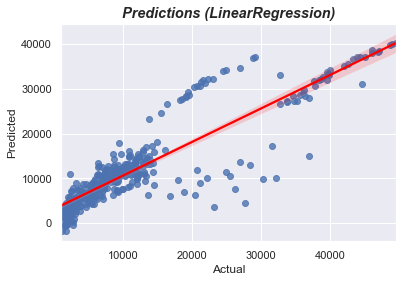

In [18]:
# Displays a plot of actual against predicted values for LinearRegression model
sns.reset_orig()
sns.set_theme()
linreg_fig = sns.regplot(x="Actual", y="Predicted", data=pd.DataFrame({"Actual": y_test, "Predicted": y_pred}), 
                         line_kws={"color": "red"})
linreg_fig.set_title("Predictions (LinearRegression)", size="large", style="italic", weight="bold")
# linreg_fig.get_figure().savefig("../models/linreg_fig01.png", bbox_inches="tight")
plt.show()

As shown in the graph, we have a considerable amount of data points that are not in correlation with the rest of the model, as shown by their significant distance from the regression line. In order to handle this, we shall apply standardisation (also known as normalisation) using the `sklearn` module; this is necessary in further removing noise from the data.

## Standardising the data

We must normalise our data in order to overcome any outliers, as mentioned above. For this, we will use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform) function provided by the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class within the `sklearn` module to scale a copy of the dataset accordingly.

In [19]:
# Required classes/modules
from sklearn.preprocessing import StandardScaler

# Creates a StandardScaler instance to transform data
ss = StandardScaler()
df_scaled = df_proc.copy(deep=True)
df_scaled[["age", "bmi", "children"]] = ss.fit_transform(df_proc[["age", "bmi", "children"]])
df_scaled.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,16884.92400,1,0,0,1,0,0,0,1
1,-1.509965,0.509621,-0.078767,1725.55230,0,1,1,0,0,0,1,0
2,-0.797954,0.383307,1.580926,4449.46200,0,1,1,0,0,0,1,0
3,-0.441948,-1.305531,-0.908614,21984.47061,0,1,1,0,0,1,0,0
4,-0.513149,-0.292556,-0.908614,3866.85520,0,1,1,0,0,1,0,0


As shown in the preview of the `DataFrame` above, the non-target features we have specified have been normalised. In the cell below, we have redefined our feature and target data to account for this.

In [20]:
# Recollects feature and target data from copy of normalised DataFrame
X_scaled = df_scaled[[x for x in df_scaled.columns if not "charges" in x]].values
y_scaled = df_scaled["charges"].values

# Outputs the first 5 values from the scaled feature and target data
print(f">>  Feature data (scaled):\n{X_scaled[:5]}\n")
print(f">>   Target data (scaled):\n{y_scaled[:5]}")

>>  Feature data (scaled):
[[-1.43876426 -0.45332    -0.90861367  1.          0.          0.
   1.          0.          0.          0.          1.        ]
 [-1.50996545  0.5096211  -0.07876719  0.          1.          1.
   0.          0.          0.          1.          0.        ]
 [-0.79795355  0.38330685  1.58092576  0.          1.          1.
   0.          0.          0.          1.          0.        ]
 [-0.4419476  -1.30553108 -0.90861367  0.          1.          1.
   0.          0.          1.          0.          0.        ]
 [-0.51314879 -0.29255641 -0.90861367  0.          1.          1.
   0.          0.          1.          0.          0.        ]]

>>   Target data (scaled):
[16884.924    1725.5523   4449.462   21984.47061  3866.8552 ]


In [21]:
# Produces training and testing subsets with scaled data for a new LinearRegression model and prediction
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=611)

linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

linreg_cv = cross_val_score(linreg_model, X_scaled, y_scaled, cv=10)    # Updates CV score
y_pred = linreg_model.predict(X_test)                                  # Updates prediction

# Outputs updated performance values
mean = np.mean(y_test)
print(f">>     CV score: {linreg_cv.mean()}")
print(f">>         Mean: {mean}")
print(f">>  10% of Mean: {mean*0.1}")
print(f">>         RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")

>>     CV score: 0.7444918139951107
>>         Mean: 13215.421687791046
>>  10% of Mean: 1321.5421687791047
>>         RMSE: 6117.372256581002


However, we can see from the performance values, specifically the CV score (identical to unnormalised), that scaling features has made no difference to the overall accuracy of the model.

## Prediction using a Support Vector Machine (Regression)

Another type of model used in our analysis are support vector machines (SVM), which are widely used in machine learning problems dealing with classification. Although we have a regression problem at hand, the principles of SVMs can still be applied.

This supervised learning algorithm tries to achieve the best separation of given data within the margins (known as decision boundaries) either side of a dividing line or curve (referred to as a hyperplane in higher dimensions) by maximizing them such that the points closest to the hyperplane are within this boundary.

We require the [`SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) class available in the `svm` module within `sklearn` in order to build the SVR model. The cell below makes use of both [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR.fit) with the training data and [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR.predict) with the testing data in an identical way to our linear regression model.

In [22]:
# Required classes/modules
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Repeats steps from previous cells to split data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=87)

# Initialises the SVR model
svr_model = SVR()

# Defines hypertuning parameters
params = {
    "kernel": ["rbf", "sigmoid", "linear"],
    "gamma": [0.001, 0.01, 0.1, 1, "scale"],
    "tol": [0.0001],
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

# Performs GridSearch with specified params
svr_model = GridSearchCV(estimator=svr_model, 
                         param_grid=params,
                         cv=10,
                         verbose=4,
                         n_jobs=-1
                        )

svr_model = svr_model.fit(X_train, y_train)    # Fits training subsets to model
svr_model_cv = svr_model.best_score_           # Calculates CV score based on GridSearch done above
y_pred = svr_model.predict(X_test)             # Produces prediction

# Outputs performance metrics for GridSearch
print(f">>  SVR model optimal params: {svr_model.best_params_}")
print(f">>                  CV score: {svr_model_cv}")

Fitting 10 folds for each of 90 candidates, totalling 900 fits
>>  SVR model optimal params: {'C': 100, 'gamma': 0.001, 'kernel': 'linear', 'tol': 0.0001}
>>                  CV score: 0.5744272686770665


As shown by the performance metrics above, a CV score of 57.4% for the SVR model built indicates relatively poor accuracy. The following cell will scale both feature and target data and reperform the hyptertuning process.

In [23]:
# Scales feature and target data
X_scal = ss.fit_transform(X)
y_scal = ss.fit_transform(y.reshape(-1, 1))

# Splits scaled data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_scal, y_scal, test_size=0.25, random_state=87)

# Performs new GridSearch with params defined previously
svr_model = SVR()
svr_model = GridSearchCV(estimator=svr_model, 
                         param_grid=params,
                         cv=10,
                         verbose=4,
                         n_jobs=-1
                        )

svr_model = svr_model.fit(X_train, y_train.flatten())    # Fits training subsets to model
svr_model_cv = svr_model.best_score_                     # Updates CV score
y_pred = svr_model.predict(X_test)                       # Updates prediction

# Outputs updated performance metrics for GridSearch
print(f">>  SVR model optimal params: {svr_model.best_params_}")
print(f">>                  CV score: {svr_model_cv}")

Fitting 10 folds for each of 90 candidates, totalling 900 fits
>>  SVR model optimal params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'tol': 0.0001}
>>                  CV score: 0.8515010188236165


Scaling both the feature and target data based on `X` and `y` has made a huge difference in the accuracy of the SVR model, as the CV score has increased by almost half of the initial value observed for this metric.

## Prediction using a Decision Tree Regressor

Decision tree regression observes features of an object and trains a model in the structure of a tree to predict data in the future to produce meaningful continuous output.

In [24]:
# Required classes/modules
from sklearn.tree import DecisionTreeRegressor

# Repeats steps from cell above to split data into training and testing subsets
X = df_proc[[x for x in df_proc.columns if not "charges" in x]].values
y = df_proc["charges"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68)

# Initialises DecisionTreeRegression model, produces a prediction and outputs the first 5 values
dt_model = DecisionTreeRegressor()

# Defines hypertuning parameters
params = {
    "max_depth": np.arange(1, 21),
    "min_samples_leaf": [1, 5, 10, 20, 50, 100],
    "min_samples_split": np.arange(2, 11),
    "criterion": ["mse"],
    "random_state": [42]
}

# Performs GridSearch with given params
dt_model = GridSearchCV(estimator=dt_model,
                        param_grid=params,
                        cv=10,
                        verbose=4,
                        n_jobs=-1
                       )

dt_model = dt_model.fit(X_train, y_train)
dt_model_cv = dt_model.best_score_

# Outputs performance metrics for GridSearch
print(f">>  DT model optimal params: {dt_model.best_params_}")
print(f">>                 CV score: {dt_model_cv}")

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits
>>  DT model optimal params: {'criterion': 'mse', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42}
>>                 CV score: 0.8504449517132711


## Prediction using Polynomial Regression (2nd Degree)

In [25]:
# Required imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=909) 

polyreg_model = make_pipeline(PolynomialFeatures(2),LinearRegression())
polyreg_model = polyreg_model.fit(X_train, y_train)

# Evaluates accuracy of Polynomial Regression model through CV score
polyreg_model_cv = cross_val_score(polyreg_model, X, y, cv=10)
y_pred = polyreg_model.predict(X_test)  

# Outputs of performance values
mean = np.mean(y_test)
print(f">>     CV score: {polyreg_model_cv.mean()}")
print(f">>         Mean: {mean}")
print(f">>  10% of Mean: {mean*0.1}")
print(f">>         RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")

>>     CV score: 0.7639852437180998
>>         Mean: 12607.678939074629
>>  10% of Mean: 1260.767893907463
>>         RMSE: 4711.762278571


## Prediction using Lasso Regression

In [26]:
# Required imports
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=64)

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(2)),
    ('model', Lasso())
]

lasso_model_pipe = Pipeline(steps)

# Defines hypertuning parameters
params = {
    "model__alpha": [1],
    "model__fit_intercept" : [True],
    "model__tol" : [0.0001],
    "model__max_iter" : [2000, 3000, 4000, 5000, 6000],
    "model__random_state": [909]
}

# Performs GridSearch with given params
lasso_model = GridSearchCV(estimator=lasso_model_pipe,
                               param_grid=params,
                               cv=10,
                               verbose=4,
                               n_jobs=-1
                          )

lasso_model = lasso_model.fit(X_train, y_train.ravel())

lasso_model_cv = lasso_model.best_score_
y_pred = lasso_model.predict(X_test)

# Outputs of performance values
mean = np.mean(y_test)
print(f">>  DT model optimal params: {lasso_model.best_params_}")
print(f">>                 CV score: {lasso_model_cv}")
print(f">>                     Mean: {mean}")
print(f">>              10% of Mean: {mean*0.1}")
print(f">>                     RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")

Fitting 10 folds for each of 5 candidates, totalling 50 fits
>>  DT model optimal params: {'model__alpha': 1, 'model__fit_intercept': True, 'model__max_iter': 3000, 'model__random_state': 909, 'model__tol': 0.0001}
>>                 CV score: 0.8296960546750739
>>                     Mean: 13042.83541489552
>>              10% of Mean: 1304.2835414895521
>>                     RMSE: 4641.73162068854
